# Simple RNN 

In this notebook we consider a simple example of an RNN and used a quite artifical data generating process (if you have a better idea / story please contact me). 

The example has been motivated by:
http://r2rt.com/recurrent-neural-networks-in-tensorflow-i.html. 

Other Resources for RNNs:

* http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/
* http://r2rt.com/recurrent-neural-networks-in-tensorflow-i.html
* http://karpathy.github.io/2015/05/21/rnn-effectiveness/
* http://colah.github.io/posts/2015-08-Understanding-LSTMs/
* http://www.deeplearningbook.org/contents/rnn.html

In [1]:
from six.moves.cPickle import loads
import numpy as np
import sys
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(1)

import tensorflow
import tensorflow as tf
keras = tensorflow.keras
%matplotlib inline
import matplotlib.pyplot as plt
tf.__version__, sys.version_info

('2.0.0',
 sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0))

In [2]:
# Global config variables (see below)
num_steps = 40     # number of truncated backprop steps
batch_size = 200  # number of minibatches b
num_classes_in = 3   # number of classes in the input
num_classes_out = 2   # number of classes in the output
state_size = 4    # number of classes in the state
learning_rate = 0.1

# Helper functions
def one_hot(Y, max):
    d = np.zeros((len(Y),max), dtype='int32')
    for row,col in enumerate(Y):
        d[row, col] = 1
    return d    

### Definition of the task

We consider a network which predicts at each point in time a variable $\hat{y}_t$ based on earlier values of $\hat{y}_{t'}$ covariates $x_t$. 

### Example data  (I screama, you screama, we all screama for I screama)

We need some data to play around with RNNs. They are capable of doing quite complicated things such as language models and so on. For this example, we want to generate the data ourself. We have to come up with a process which creates $x_t$ which itself can be influcenced by events $x_{t'}$ which happend before $t$. Further, we have to come up with $y_t$ which depends on $x_t'$ for timepoints $t' \le t$. 

To keep it simple, we analyse the following quite artifical process in which the weather $x_{t'}$ for $t' \le t$ influences our stock on icecream $y_t$. We then see if the RNN is capable of reconstructing that process.

#### Definition of the simple process
The weather $x_t$ at a certain point in time $t$ has three states (sunny, rainy, cloudy), which we model as $x_t = (1,0,0)$, $x_t = (0,1,0)$, and $x_t = (0,0,1)$ repectively. We assume that the weather is completly random (of course we could model more complex scenarios). 

We have an icecream store capable of holding 2 units of icecream and we start with a full store. When it is sunny we sell one unit of icecream. We have the strange policy that we order  on unit of icecream when it's cloudy. It takes 3 days to deliever the ice cream, we accept the ice cream if we do not have a full stock.

This enables us to model $y_t$ the state of the store $(1,0)$ for out of stock and $(0,1)$ for in stock. We create the one-hot-encoded data in the graph later. For now we use integers but keep in mind that the data is categorical. 

** The important part is that, we have values $y_t$ which can be prediced from earlier** $x_t$s

In [3]:
def gen_data(size=1000000):
    Xs = np.array(np.random.choice(3, size=(size,))) #Random Weather
    Y = []
    ice = 2 #Our stock of icecream at start
    for t,x in enumerate(Xs):
        # (t-3) >= 0 the first ice cream could be delivered on day 3
        # Xs[t - 3] claudy three days before today => we ordered ice cream
        # ice < 2 not full
        if (t - 3) >= 0 and Xs[t - 3] == 1 and ice < 2: 
            ice += 1
        if x == 0: # It is sunny we therefore sell ice, if we have
            if ice > 0: # We have ice cream
                ice -= 1
        if ice > 0: #We are not out of stock
            Y.append(1)
        else:
            Y.append(0)
    return Xs, np.array(Y)

In [4]:
X_train, Y_train = gen_data(50000) #Global variables holding the input and output
(X_train[0:50], Y_train[0:50])

(array([2, 0, 2, 2, 0, 0, 2, 1, 2, 2, 2, 2, 0, 2, 1, 0, 1, 1, 1, 1, 0, 0,
        1, 1, 0, 0, 0, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 0, 2, 0, 2, 2, 0,
        0, 2, 1, 0, 1, 1]),
 array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1]))

# Forward pass in numpy
To better illustrate the used method, we first do a forward-pass of the RNN using numpy. We load the weights which we calculated previously with the cells below.

In [5]:
W_, b_, V_, bv_ = np.load('rnn_weights_tf1.npy', allow_pickle=True)

### Architecture of the network 
We now define the network, we do not consider the output nodes yet.
A single RNN cell is shown in the figure below in the middle:

![](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png)
Image taken from: [Colah's RNN Blog](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

The joining of the two lines coming from the previous state $h_{t-1}$ and the current x-values $x_t$ is a concantination to a vector  $[h_{t-1}, x_{t}]$ of size `state_size + num_classes_in`. Alternatively, instead of concatinating, one could also use two matrices $W_x$ and $W_h$ and keep the states seperate. This is mathematically completely identical. The new state $h_t$ is then calculated as:

$$
    h_{t} = \tanh([h_{t-1}, x_{t}] \cdot W + b) = \tanh(h_{t-1} \cdot W_h + x_{t} \cdot U + b)
$$

The dynamic of the hidden state $h_{t}$ is determined by $W$ (and $b$):

In [6]:
W_, b_

(array([[-0.19089293,  1.2079829 ,  0.00908419, -0.9110236 ],
        [-1.0788563 , -0.34288317,  0.7271212 ,  1.4178839 ],
        [-0.20597383, -0.19254826,  0.7025221 , -0.54543966],
        [ 1.0341463 ,  0.67596245, -0.93610775,  0.37894768],
        [-0.16711316,  1.0264009 , -0.89726377, -0.42267284],
        [ 0.20204762, -1.2146151 ,  0.02345279,  0.41776735],
        [-1.4482121 ,  0.28976035, -1.8760067 , -1.1563133 ]],
       dtype=float32),
 array([ 0.1347418 ,  0.28151226,  0.17300364, -0.321079  ], dtype=float32))

In [24]:
# The first state
h0 = np.zeros(state_size) #We start with 0 initial state
x1 = one_hot(X_train, num_classes_in)[0] #Make a vector
h1 = np.tanh(np.matmul(np.concatenate([x1, h0]), W_) + b_)
print(h0, "--->", h1)

[0. 0. 0. 0.] ---> [-0.0711118   0.08873004  0.70417075 -0.69960102]


We could repeat those transitions of the hidden states to get a sequence of hidden states:

$h_0 \rightarrow h_1 \rightarrow h_2 \rightarrow h_3 \rightarrow h_4 \ldots $

In [25]:
def rnn_forward(state, X_train):
    hs = []
    for t in range(len(X_train)):
        # Note that TF concatenates [Input, State]
        state = np.tanh(np.matmul(np.concatenate([X_train[t,:],state]), W_) + b_)
        hs.append(state)
    return hs

In [26]:
rnn_forward(h0, one_hot(X_train[0:5],num_classes_in))

[array([-0.0711118 ,  0.08873004,  0.70417075, -0.69960102]),
 array([ 0.76614542,  0.4418166 ,  0.90478852, -0.19104017]),
 array([ 0.80289923, -0.09371934,  0.14058029, -0.16258438]),
 array([ 0.77733682,  0.30737024,  0.47485703, -0.26912559]),
 array([ 0.82809942,  0.93229872, -0.29620752, -0.50640012])]

We add some output. For each time step the output is produced by multiplying the hidden state with:

$o_t = h_t \cdot V + b_{\tt{v}}$

This is a logit, the final the probability of output class is the softmax of the logit.

In [10]:
#<---- your code here (calculate the output state o1 for timestep 1 from h1, V_ and the bias bv_) ---->
o1 = np.matmul(h1, V_) + bv_
#<---- your code here (calculate probability from the state o1) using softmax ---->
prob_1 = np.exp(o1)/np.sum(np.exp(o1))
#<---- end your code here  ---->
o1, prob_1

(array([-0.24407249,  0.67026118]), array([0.28611385, 0.71388615]))

In [11]:
h = rnn_forward(h0, one_hot(X_train,3))
pt = []
for t in range(len(h)):
    ot = np.matmul(h[t], V_) + bv_
    pt.append(np.exp(ot)/np.sum(np.exp(ot)))

In [12]:
pt[0:10], np.argmax(pt[0:30],axis=1), Y_train[0:30]

([array([0.28611385, 0.71388615]),
  array([0.72571267, 0.27428733]),
  array([0.16161706, 0.83838294]),
  array([0.58954736, 0.41045264]),
  array([0.98113328, 0.01886672]),
  array([0.98589376, 0.01410624]),
  array([0.9805026, 0.0194974]),
  array([0.97813046, 0.02186954]),
  array([0.98805885, 0.01194115]),
  array([0.96179709, 0.03820291])],
 array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0]),
 array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]))

In [13]:
np.average(np.argmax(pt, axis=1) == Y_train)

0.98318

In [14]:
tot_loss = 0
for i in range(len(Y_train)):
    tot_loss += -np.log(pt[i][Y_train[i]])

In [15]:
tot_loss / len(Y_train)

0.06928991983381633

# Training of the network
## Preparation of the Minibatch

In this example, we have in principle a large stream of data $x$ and $y$. For efficiency reason we split the stream in minibatches of a certain length. For this task we could also imagin to have several realizations of that icecream process, so that it would also be natural to split the process into mini batches. 

For simplicity, we create the minibatch by randomly cutting out `batch_size` entries of fixed length `num_steps`. Other, more advanced ways of doing so are possible. See e.g. https://danijar.com/variable-sequence-lengths-in-tensorflow/. For the time being, we thus consider the input tensor $X_{btc}$ for the minibatch to be of the following form:

* $b$ having `batch_size` entries
* $t$ loops over the unrolled timestamps (`num_steps`)
* $c$ has the dimension of the one-hot-coded input classes 

In [16]:
def data_matrix(Xs, Ys, size = 32, num_steps = 50):
    data_x = np.zeros([size, num_steps, 3], dtype=np.int32)
    data_y = np.zeros([size, num_steps, 2], dtype=np.int32)
    for i in range(1,size):
        s = int(np.random.uniform(0, len(Xs) - num_steps))
        data_x[i] = one_hot(Xs[s : s + num_steps],3)
        data_y[i] = one_hot(Ys[s : s + num_steps],2)
    return data_x, data_y

In [17]:
X, Y = data_matrix(X_train, Y_train, size=10000, num_steps=num_steps)
X.shape, Y.shape
#print (X[0:2,0:5])
#print (Y[0:2,0:5])

((10000, 40, 3), (10000, 40, 2))

## Building the model with keras

**Keras assumes (batch, time, input_dimension)** as input tensor. The batch dimension needs not to be specified (side note that specifying it to `None` would not work).


In our model we calculate the loss using all hidden timepoints. This is many-to-many situation is different for example to a sentiment classifier, where we we have a many-to-one situation. 

Not just the latest one (in time). Hence we set `return_sequences=True`.

In [18]:
model = keras.models.Sequential()
rnn = keras.layers.SimpleRNN(state_size, input_shape=(num_steps, 3), return_sequences=True, name='RNN')
model.add(rnn) 
#model.input_shape --> (None, 40, 3)
#model.output_shape --> (None, 40, 4) 

# <-- Your code here 
# Add an output layer connecting with the hidden state of the RNN
model.add(keras.layers.Dense(2))
# <-- End code here 

#model.output_shape --> (None, 40, 2) 
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [19]:
history = model.fit(X, Y, epochs=100, verbose=2, validation_split=0.05)

Train on 9500 samples, validate on 500 samples
Epoch 1/100
9500/9500 - 3s - loss: 3.0026 - accuracy: 0.5221 - val_loss: 1.4293 - val_accuracy: 0.5238
Epoch 2/100
9500/9500 - 2s - loss: 0.8383 - accuracy: 0.5698 - val_loss: 0.6614 - val_accuracy: 0.6714
Epoch 3/100
9500/9500 - 2s - loss: 0.5912 - accuracy: 0.7140 - val_loss: 0.5186 - val_accuracy: 0.7640
Epoch 4/100
9500/9500 - 2s - loss: 0.4379 - accuracy: 0.8020 - val_loss: 0.4031 - val_accuracy: 0.8186
Epoch 5/100
9500/9500 - 2s - loss: 0.3774 - accuracy: 0.8306 - val_loss: 0.3573 - val_accuracy: 0.8423
Epoch 6/100
9500/9500 - 2s - loss: 0.3290 - accuracy: 0.8593 - val_loss: 0.3053 - val_accuracy: 0.8763
Epoch 7/100
9500/9500 - 2s - loss: 0.2801 - accuracy: 0.8937 - val_loss: 0.2624 - val_accuracy: 0.9097
Epoch 8/100
9500/9500 - 2s - loss: 0.2536 - accuracy: 0.9128 - val_loss: 0.2510 - val_accuracy: 0.9144
Epoch 9/100
9500/9500 - 2s - loss: 0.2463 - accuracy: 0.9152 - val_loss: 0.2451 - val_accuracy: 0.9136
Epoch 10/100
9500/9500 - 2

Epoch 80/100
9500/9500 - 2s - loss: 0.1829 - accuracy: 0.9479 - val_loss: 0.1992 - val_accuracy: 0.9472
Epoch 81/100
9500/9500 - 2s - loss: 0.1822 - accuracy: 0.9479 - val_loss: 0.1993 - val_accuracy: 0.9466
Epoch 82/100
9500/9500 - 2s - loss: 0.1823 - accuracy: 0.9480 - val_loss: 0.2002 - val_accuracy: 0.9465
Epoch 83/100
9500/9500 - 2s - loss: 0.1833 - accuracy: 0.9481 - val_loss: 0.1988 - val_accuracy: 0.9475
Epoch 84/100
9500/9500 - 2s - loss: 0.1823 - accuracy: 0.9481 - val_loss: 0.1983 - val_accuracy: 0.9478
Epoch 85/100
9500/9500 - 2s - loss: 0.1816 - accuracy: 0.9489 - val_loss: 0.1992 - val_accuracy: 0.9479
Epoch 86/100
9500/9500 - 2s - loss: 0.1828 - accuracy: 0.9486 - val_loss: 0.1975 - val_accuracy: 0.9457
Epoch 87/100
9500/9500 - 2s - loss: 0.1840 - accuracy: 0.9482 - val_loss: 0.1982 - val_accuracy: 0.9470
Epoch 88/100
9500/9500 - 2s - loss: 0.1828 - accuracy: 0.9477 - val_loss: 0.1976 - val_accuracy: 0.9469
Epoch 89/100
9500/9500 - 2s - loss: 0.1815 - accuracy: 0.9488 - 

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RNN (SimpleRNN)              (None, 40, 4)             32        
_________________________________________________________________
dense (Dense)                (None, 40, 2)             10        
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________


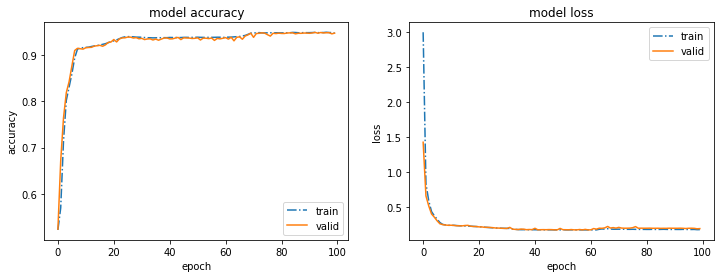

In [21]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

In [22]:
# We use the training, since we did use only a random subset of the data
X, Y = data_matrix(X_train, Y_train, size=1000, num_steps=num_steps)
model.evaluate(X,Y, verbose=0)

[0.1899680873155594, 0.9499875]

In [23]:
rnn.get_weights()

[array([[-0.21605968, -0.02948334,  0.13601376, -1.2223743 ],
        [ 0.10594247,  1.8724391 ,  0.23321001,  0.2734687 ],
        [ 0.16046026, -0.04228318,  0.12141945,  0.24082775]],
       dtype=float32),
 array([[ 0.7338864 , -0.0139803 , -0.07297333,  1.531527  ],
        [ 0.19304346,  0.0433125 , -1.7489346 ,  0.02920447],
        [-2.6149638 ,  0.02548098, -0.17421581, -0.21342318],
        [ 0.10220984, -0.00775155, -0.03905404,  1.0599148 ]],
       dtype=float32),
 array([ 0.1745347 , -0.187638  , -0.39152995, -0.49653885], dtype=float32)]